In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from typing import Tuple, Dict, List, Optional
import math
from tqdm import tqdm

In [236]:
class AccurateBoucWenSimulator:    
    def __init__(self):
        # 더 안전한 기본 파라미터 범위
        self.default_params = {
            'alpha': 0.2,    # 탄성 비율 (0.1 → 0.2)
            'beta': 0.5,     # β 
            'gamma': 0.5,    # γ
            'n': 1.0,        # n (매끄러움)
            'k': 1.0,        # k_i (강성)
            'A': 1.0         # A (정규화 인자)
        }
    
    def bouc_wen_ode_stable(self, state, t, displacement, time, alpha, beta, gamma, n, k, A):
        """
        수정 중인데 뭔가 이상함
        """
        z = state[0]
        
        # 속도 계산
        dt = time[1] - time[0] if len(time) > 1 else 0.01
        idx = np.searchsorted(time, t)
        
        if idx == 0:
            u_dot = (displacement[1] - displacement[0]) / dt if len(displacement) > 1 else 0
        elif idx >= len(displacement):
            u_dot = (displacement[-1] - displacement[-2]) / dt if len(displacement) > 1 else 0
        else:
            u_dot = (displacement[idx] - displacement[idx-1]) / dt
        
        u_dot = np.clip(u_dot, -10.0, 10.0)
        z = np.clip(z, -5.0, 5.0)

        # dz/dt 계산 (alpha는 여기서 사용하지 않음)
        if abs(z) < 1e-8:
            term1 = 0
            term2 = 0
        else:
            term1 = beta * abs(u_dot) * (abs(z) ** (n-1)) * z
            term2 = gamma * u_dot * (abs(z) ** n)
        
        dzdt = A * (u_dot - term1 - term2)
        dzdt = np.clip(dzdt, -50.0, 50.0)
        
        return [dzdt]
    
    def simulate_constant_params_stable(self, 
                                      displacement: np.ndarray,
                                      time: np.ndarray,
                                      params: dict = None,
                                      z0: float = 0.0) -> tuple:
        """안정한 정상 데이터 시뮬레이션"""
        if params is None:
            params = self.default_params.copy()
        
        # z 적분 (올바른 ODE 사용)
        z_solution = odeint(self.bouc_wen_ode_stable, [z0], time, 
                        args=(displacement, time, 
                                params['alpha'], params['beta'], params['gamma'],
                                params['n'], params['k'], params['A']))
        
        z_history = z_solution[:, 0]
        
        # 올바른 복원력 계산: F(t) = a*k*u(t) + (1-a)*k*z(t)
        force = (params['alpha'] * params['k'] * displacement + 
                (1 - params['alpha']) * params['k'] * z_history)
        
        return force, z_history
    
    def _integrate_in_chunks(self, displacement, time, velocity, params, z0):
        chunk_size = 200
        n_points = len(time)
        z_history = np.zeros(n_points)
        z_history[0] = z0
        
        for i in range(0, n_points, chunk_size):
            end_idx = min(i + chunk_size, n_points)
            
            if i == 0:
                chunk_z0 = z0
            else:
                chunk_z0 = z_history[i-1]

            chunk_solution = odeint(
                self.bouc_wen_ode_stable, [chunk_z0], time[i:end_idx],
                args=(displacement, time, velocity,
                        params['alpha'], params['beta'], params['gamma'],
                        params['n'], params['k'], params['A']),
                atol=1e-8, rtol=1e-6
            )
            z_history[i:end_idx] = chunk_solution[:, 0]
    
        return z_history
    
    def simulate_varying_params_stable(self,
                                     displacement: np.ndarray,
                                     time: np.ndarray,
                                     param_trajectories: dict,
                                     z0: float = 0.0) -> tuple:
        n_steps = len(time)
        z_history = np.zeros(n_steps)
        force = np.zeros(n_steps)
        
        z_history[0] = 0
        
        # 입력 제한
        displacement = np.clip(displacement, -5.0, 5.0)
        
        # 속도 계산
        velocity = np.zeros_like(displacement)
        dt = time[1] - time[0] if len(time) > 1 else 0.01
        
        if len(displacement) > 2:
            velocity[1:-1] = (displacement[2:] - displacement[:-2]) / (2 * dt)
            velocity[0] = (displacement[1] - displacement[0]) / dt
            velocity[-1] = (displacement[-1] - displacement[-2]) / dt
                
        # 시간 스텝별 적분
        for i in range(1, n_steps):
            # 현재 파라미터 값들 (안전하게)
            current_params = {}
            for param_name, trajectory in param_trajectories.items():
                value = trajectory[i-1]
                if param_name == 'alpha':
                    current_params[param_name] = np.clip(value, 0.01, 0.99)
                elif param_name in ['beta', 'gamma']:
                    current_params[param_name] = np.clip(value, 0.1, 2.0)
                elif param_name == 'n':
                    current_params[param_name] = np.clip(value, 0.5, 3.0)
                elif param_name in ['k', 'A']:
                    current_params[param_name] = np.clip(value, 0.1, 2.0)
                else:
                    current_params[param_name] = value
            
            # 기본값 채우기
            for param_name, default_value in self.default_params.items():
                if param_name not in current_params:
                    current_params[param_name] = default_value
            
            # 현재 스텝 계산
            z_prev = np.clip(z_history[i-1], -5.0, 5.0)
            u_dot = np.clip(velocity[i-1], -20.0, 20.0)
            
            # z_power_sgn_term 안전 계산
            if abs(z_prev) < 1e-8:
                z_power_sgn_term = 0
            else:
                z_abs = abs(z_prev)
                n_val = current_params['n']
                if z_abs > 1e-3:
                    z_power_sgn_term = np.sign(z_prev) * (z_abs ** (n_val - 1))
                else:
                    z_power_sgn_term = np.sign(z_prev) * (1e-3 ** (n_val - 1))
                z_power_sgn_term = np.clip(z_power_sgn_term, -100.0, 100.0)

            # Bouc-Wen 방정식
            term1 = u_dot
            term2 = current_params['beta'] * z_prev
            term3 = current_params['gamma'] * z_prev * z_power_sgn_term
            
            dzdt = current_params['A'] * (term1 - term2 - term3)
            dzdt = np.clip(dzdt, -20.0, 20.0)
            
            if not np.isfinite(dzdt):
                dzdt = 0.0
            
            z_history[i] = z_prev + dzdt * dt
            z_history[i] = np.clip(z_history[i], -5.0, 5.0)
            
            # 복원력 계산
            elastic_term = current_params['alpha'] * current_params['k'] * displacement[i]
            hysteretic_term = (1 - current_params['alpha']) * current_params['k'] * z_history[i]
            
            force[i] = elastic_term + hysteretic_term
            force[i] = np.clip(force[i], -50.0, 50.0)
            
            if not np.isfinite(force[i]):
                force[i] = 0.0
        
        return force, z_history
    
    def generate_sinusoidal_displacement(self, 
                                       amplitude: float = 1.0,
                                       frequency: float = 1.0,
                                       duration: float = 10.0,
                                       sampling_rate: float = 100.0,
                                       phase: float = 0.0) -> tuple:
        # 파라미터 제한
        amplitude = np.clip(amplitude, 0.1, 3.0)  # 진폭 제한
        frequency = np.clip(frequency, 0.1, 2.0)  # 주파수 제한
        
        time = np.linspace(0, duration, int(duration * sampling_rate))
        displacement = amplitude * np.sin(2 * np.pi * frequency * time + phase)
        
        return time, displacement
    
    def create_safe_fault_scenario(self,
                                 fault_type: str,
                                 time: np.ndarray,
                                 transition_start_ratio: float = 0.3,
                                 severity: float = 2.0) -> dict:
        n_steps = len(time)
        transition_start = int(n_steps * transition_start_ratio)
        
        # 심각도 제한
        severity = np.clip(severity, 1.2, 3.0)
        
        # 기본 파라미터로 초기화
        param_trajectories = {}
        for param_name, default_value in self.default_params.items():
            param_trajectories[param_name] = np.full(n_steps, default_value)
        
        if fault_type == 'stiffness_loss':
            # alpha 점진적 감소 (더 완만하게)
            for i in range(transition_start, n_steps):
                progress = (i - transition_start) / (n_steps - transition_start)
                # 더 보수적인 변화
                reduction_factor = 0.3 * progress  # 최대 30% 감소
                new_alpha = self.default_params['alpha'] * (1 - reduction_factor)
                param_trajectories['alpha'][i] = np.clip(new_alpha, 0.05, 0.95)
                
        elif fault_type == 'damping_change':
            # beta 점진적 증가
            for i in range(transition_start, n_steps):
                progress = (i - transition_start) / (n_steps - transition_start)
                increase_factor = 0.5 * progress  # 최대 50% 증가
                new_beta = self.default_params['beta'] * (1 + increase_factor)
                param_trajectories['beta'][i] = np.clip(new_beta, 0.1, 1.5)
                
        elif fault_type == 'nonlinearity_increase':
            # gamma 점진적 증가
            for i in range(transition_start, n_steps):
                progress = (i - transition_start) / (n_steps - transition_start)
                increase_factor = 0.4 * progress  # 최대 40% 증가
                new_gamma = self.default_params['gamma'] * (1 + increase_factor)
                param_trajectories['gamma'][i] = np.clip(new_gamma, 0.1, 1.2)
        
        return param_trajectories

In [237]:
def adjust_sequence_length(displacement, time, target_length, duration):
    current_length = len(displacement)
    
    if current_length > target_length:
        displacement = displacement[:target_length]
        time = time[:target_length]
    elif current_length < target_length:
        time_new = np.linspace(0, duration, target_length)
        displacement = np.interp(time_new, time, displacement)
        time = time_new
    
    return displacement, time

def create_constant_param_trajectory(params, seq_len):
    param_names = ['alpha', 'beta', 'gamma', 'n', 'k', 'A']
    trajectory = np.zeros((seq_len, len(param_names)))
    
    for i, param_name in enumerate(param_names):
        trajectory[:, i] = params[param_name]
    
    return trajectory

def convert_param_dict_to_array(param_trajectories, seq_len):
    param_names = ['alpha', 'beta', 'gamma', 'n', 'k', 'A']
    trajectory = np.zeros((seq_len, len(param_names)))
    
    for i, param_name in enumerate(param_names):
        trajectory[:, i] = param_trajectories[param_name]
    
    return trajectory


In [327]:
def generate_complete_dataset(
    simulator,
    n_normal: int = 300,
    n_fault_per_type: int = 50,
    seq_len: int = 1000,
    duration: float = 10.0,
    sampling_rate: float = 100.0):
    
    all_displacement = []
    all_force = []
    all_params = []
    all_labels = []
    
    # 더 보수적인 파라미터 범위
    param_ranges = {
        'alpha': [0.3, 0.4], #[0.1, 0.4],
        'beta': [0.5,0.5], # [0.3, 1.0],
        'gamma': [0.5, 0.5], #[0.3, 1.0],
        'n': [1,1], #[1.0, 2.0],
        'k': [1,1], #[0.8, 1.5],
        'A': [1,1], #[0.8, 1.2]
    }
    
    # 정상 데이터 생성
    print(f"정상 데이터 {n_normal}개 생성 중...")
    
    for i in tqdm(range(n_normal), desc="정상 데이터 생성"):
        # 안전한 파라미터 조합
        params = {}
        for param_name, (min_val, max_val) in param_ranges.items():
            params[param_name] = np.random.uniform(min_val, max_val)
        
        # 더 보수적인 입력 신호
        amplitude = np.random.uniform(0.5, 2.0)
        frequency = np.random.uniform(0.3, 1.2)
        phase = np.random.uniform(0, 2*np.pi)
        
        time, displacement = simulator.generate_sinusoidal_displacement(
            amplitude=amplitude, frequency=frequency, duration=duration,
            sampling_rate=sampling_rate, phase=phase
        )
        
        # 길이 조정
        displacement, time = adjust_sequence_length(displacement, time, seq_len, duration)
        
        # 안전한 시뮬레이션
        force, z_history = simulator.simulate_constant_params_stable(displacement, time, params)
                
        param_trajectory = create_constant_param_trajectory(params, seq_len)
        
        all_displacement.append(displacement)
        all_force.append(force)
        all_params.append(param_trajectory)
        all_labels.append(0)
    
    # 불량 데이터 생성
    fault_types = ['stiffness_loss', 'damping_change', 'nonlinearity_increase']
    fault_type_mapping = {
        'stiffness_loss': 1,
        'damping_change': 2,
        'nonlinearity_increase': 3
    }
    
    for fault_type in fault_types:
        print(f"{fault_type} 불량 데이터 {n_fault_per_type}개 생성 중...")
        
        for i in tqdm(range(n_fault_per_type), desc=f"{fault_type} 데이터 생성"):
            # 보수적인 입력 신호
            amplitude = np.random.uniform(0.5, 2.0)
            frequency = np.random.uniform(0.3, 1.2)
            phase = np.random.uniform(0, 2*np.pi)
            
            time, displacement = simulator.generate_sinusoidal_displacement(
                amplitude=amplitude, frequency=frequency, duration=duration,
                sampling_rate=sampling_rate, phase=phase
            )
            
            displacement, time = adjust_sequence_length(displacement, time, seq_len, duration)
            
            # 안전한 불량 시나리오
            transition_start_ratio = np.random.uniform(0.2, 0.4)
            severity = np.random.uniform(1.5, 2.5)
            
            param_trajectories = simulator.create_safe_fault_scenario(
                fault_type=fault_type, time=time,
                transition_start_ratio=transition_start_ratio,
                severity=severity
            )
            
            # 안전한 시뮬레이션
            force, z_history = simulator.simulate_varying_params_stable(
                displacement, time, param_trajectories
            )
            
            param_trajectory = convert_param_dict_to_array(param_trajectories, seq_len)
            
            all_displacement.append(displacement)
            all_force.append(force)
            all_params.append(param_trajectory)
            all_labels.append(fault_type_mapping[fault_type])
    
    displacement_data = np.array(all_displacement)
    force_data = np.array(all_force)
    fault_labels = np.array(all_labels)
    param_data = np.array(all_params)
    
    print(f"\n=== 데이터 품질 최종 검증 ===")
    print(f"Displacement - Min: {displacement_data.min():.6f}, Max: {displacement_data.max():.6f}")
    print(f"Force - Min: {force_data.min():.6f}, Max: {force_data.max():.6f}")
    print(f"NaN 개수 - Displacement: {np.isnan(displacement_data).sum()}, Force: {np.isnan(force_data).sum()}")
    
    n_total = len(displacement_data)
    shuffle_idx = np.random.permutation(n_total)
    
    displacement_data = displacement_data[shuffle_idx]
    force_data = force_data[shuffle_idx]
    fault_labels = fault_labels[shuffle_idx]
    param_data = param_data[shuffle_idx]
    
    print(f"\n=== 안전한 데이터셋 생성 완료 ===")
    print(f"총 데이터 개수: {n_total}")
    
    return displacement_data, force_data, fault_labels, param_data

In [239]:
class BoucWenDatasetNormalized(Dataset):
    """정규화가 포함된 Bouc-Wen 히스테리시스 데이터셋"""
    def __init__(self, displacement_data, force_data, fault_labels, param_data, normalize=True):
        # 원본 데이터를 텐서로 변환
        self.displacement = torch.FloatTensor(displacement_data)
        self.force = torch.FloatTensor(force_data)
        self.fault_labels = torch.LongTensor(fault_labels)
        self.params = torch.FloatTensor(param_data)
        
        # NaN, Inf 제거
        self.displacement = torch.where(torch.isfinite(self.displacement), 
                                      self.displacement, torch.zeros_like(self.displacement))
        self.force = torch.where(torch.isfinite(self.force), 
                                self.force, torch.zeros_like(self.force))
        
        # 정규화
        if normalize:
            # Displacement 정규화
            self.disp_mean = self.displacement.mean()
            self.disp_std = self.displacement.std() + 1e-8
            self.displacement = (self.displacement - self.disp_mean) / self.disp_std
            
            # Force 정규화
            self.force_mean = self.force.mean()
            self.force_std = self.force.std() + 1e-8
            self.force = (self.force - self.force_mean) / self.force_std
            
            print(f"정규화 완료:")
            print(f"  Displacement - Mean: {self.disp_mean:.6f}, Std: {self.disp_std:.6f}")
            print(f"  Force - Mean: {self.force_mean:.6f}, Std: {self.force_std:.6f}")
        
        # 입력 데이터: displacement와 force 결합
        self.input_data = torch.stack([self.displacement, self.force], dim=-1)
        
        # 최종 안전성 체크
        self.input_data = torch.clamp(self.input_data, -10.0, 10.0)
        
    def __len__(self):
        return len(self.displacement)
    
    def __getitem__(self, idx):
        return {
            'input': self.input_data[idx],
            'displacement': self.displacement[idx],
            'force': self.force[idx],
            'fault_label': self.fault_labels[idx],
            'params': self.params[idx]
        }

In [240]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
        
    def forward(self, query, key, value, mask=None):
        batch_size, seq_len = query.size(0), query.size(1)
        
        Q = self.w_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.w_o(context), attn_weights

In [241]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

class BoucWenEncoder(nn.Module):
    def __init__(self, input_dim=2, d_model=256, n_heads=8, n_layers=6, latent_dim=64, dropout=0.1):
        super().__init__()
        
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        
        self.attention_layers = nn.ModuleList([
            nn.ModuleDict({
                'attention': MultiHeadAttention(d_model, n_heads, dropout),
                'norm1': nn.LayerNorm(d_model),
                'ffn': nn.Sequential(
                    nn.Linear(d_model, d_model * 4),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model * 4, d_model)
                ),
                'norm2': nn.LayerNorm(d_model),
                'dropout': nn.Dropout(dropout)
            }) for _ in range(n_layers)
        ])
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(d_model, 512),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.mu_layer = nn.Linear(256, latent_dim)
        self.logvar_layer = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoding(x)
        
        for layer in self.attention_layers:
            attn_out, _ = layer['attention'](x, x, x)
            x = layer['norm1'](x + layer['dropout'](attn_out))
            
            ffn_out = layer['ffn'](x)
            x = layer['norm2'](x + layer['dropout'](ffn_out))
        
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(-1)
        
        features = self.feature_extractor(x)
        mu = self.mu_layer(features)
        logvar = self.logvar_layer(features)
        
        return mu, logvar

class BoucWenDecoder(nn.Module):
    def __init__(self, latent_dim=64, d_model=256, n_heads=8, n_layers=6, 
                 output_dim=2, seq_len=1000, dropout=0.1):
        super().__init__()
        
        self.seq_len = seq_len
        self.d_model = d_model
        
        self.latent_expansion = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, 512),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, d_model * seq_len)
        )
        
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        
        self.attention_layers = nn.ModuleList([
            nn.ModuleDict({
                'attention': MultiHeadAttention(d_model, n_heads, dropout),
                'norm1': nn.LayerNorm(d_model),
                'ffn': nn.Sequential(
                    nn.Linear(d_model, d_model * 4),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model * 4, d_model)
                ),
                'norm2': nn.LayerNorm(d_model),
                'dropout': nn.Dropout(dropout)
            }) for _ in range(n_layers)
        ])
        
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, z):
        batch_size = z.size(0)
        
        x = self.latent_expansion(z)
        x = x.view(batch_size, self.seq_len, self.d_model)
        x = self.pos_encoding(x)
        
        for layer in self.attention_layers:
            attn_out, _ = layer['attention'](x, x, x)
            x = layer['norm1'](x + layer['dropout'](attn_out))
            
            ffn_out = layer['ffn'](x)
            x = layer['norm2'](x + layer['dropout'](ffn_out))
        
        return self.output_projection(x)

In [242]:
class BoucWenPhysicsLoss(nn.Module):
    """수치적 안정성을 강화한 Bouc-Wen 물리 손실 함수"""
    
    def __init__(self, dt=0.01, change_penalty_weight=5.0):
        super().__init__()
        self.dt = dt
        self.change_penalty_weight = change_penalty_weight
        
    def compute_velocity(self, displacement):
        """안전한 속도 계산"""
        batch_size, seq_len = displacement.shape
        
        if seq_len < 2:
            return torch.zeros_like(displacement)
        
        # 중앙차분법으로 속도 계산
        velocity = torch.zeros_like(displacement)
        
        # 경계 조건
        velocity[:, 0] = (displacement[:, 1] - displacement[:, 0]) / self.dt
        velocity[:, -1] = (displacement[:, -1] - displacement[:, -2]) / self.dt
        
        # 중앙차분
        if seq_len > 2:
            velocity[:, 1:-1] = (displacement[:, 2:] - displacement[:, :-2]) / (2 * self.dt)
        
        # 수치적 안정성 체크
        velocity = torch.clamp(velocity, -1000.0, 1000.0)
        
        return velocity
    
    def safe_power_operation(self, z, n):
        """안전한 거듭제곱 연산"""
        # z와 n의 수치적 안정성 보장
        z_safe = torch.clamp(z, -100.0, 100.0)
        n_safe = torch.clamp(n, 0.1, 10.0)
        
        z_abs = torch.abs(z_safe) + 1e-8
        
        power_result = torch.pow(z_abs, n_safe - 1)
        power_result = torch.where(torch.isfinite(power_result), power_result, torch.ones_like(power_result))
        power_result = torch.clamp(power_result, 0.0, 1e6)
        
        return torch.sign(z_safe) * power_result
    
    def solve_bouc_wen_z(self, displacement, velocity, params):
        """
        수치적으로 안정한 Bouc-Wen z 계산
        dz/dt = A(u̇ - βZ - γZ|Z|^(n-1)*sgn(Z))
        """
        batch_size, seq_len = displacement.shape
        device = displacement.device
        
        # z 값들을 리스트로 저장 (메모리 효율성)
        z_values = [torch.zeros(batch_size, device=device)]
        
        for t in range(1, seq_len):
            z_prev = z_values[t-1]
            u_dot = velocity[:, t-1]
            
            if len(params['A'].shape) > 1:
                A = torch.clamp(params['A'][:, t-1], 0.1, 10.0)
                beta = torch.clamp(params['beta'][:, t-1], 0.0, 10.0)
                gamma = torch.clamp(params['gamma'][:, t-1], 0.0, 10.0)
                n = torch.clamp(params['n'][:, t-1], 0.5, 5.0)
            else:
                A = torch.clamp(params['A'], 0.1, 10.0)
                beta = torch.clamp(params['beta'], 0.0, 10.0)
                gamma = torch.clamp(params['gamma'], 0.0, 10.0)
                n = torch.clamp(params['n'], 0.5, 5.0)
            
            # z 값 안전성 체크
            z_prev_safe = torch.clamp(z_prev, -10.0, 10.0)
            
            # 안전한 거듭제곱 연산
            z_power_sgn_term = self.safe_power_operation(z_prev_safe, n)
            
            # Bouc-Wen 방정식 계산
            term1 = u_dot
            term2 = beta * z_prev_safe
            term3 = gamma * z_prev_safe * z_power_sgn_term
            
            # 각 항의 안정성 체크
            term1 = torch.clamp(term1, -1000.0, 1000.0)
            term2 = torch.clamp(term2, -1000.0, 1000.0)
            term3 = torch.clamp(term3, -1000.0, 1000.0)
            
            dzdt = A * (term1 - term2 - term3)
            
            # 최종 안정성 체크
            dzdt = torch.clamp(dzdt, -100.0, 100.0)
            
            # NaN, Inf 체크
            dzdt = torch.where(torch.isfinite(dzdt), dzdt, torch.zeros_like(dzdt))
            
            # 새로운 z 값
            z_new = z_prev_safe + dzdt * self.dt
            z_new = torch.clamp(z_new, -10.0, 10.0)
            
            z_values.append(z_new)
        
        z_final = torch.stack(z_values, dim=1)
        
        return z_final
    
    def compute_bouc_wen_force(self, displacement, z, params):
        """
        안전한 복원력 계산: F(t) = a*k_i*u(t) + (1-a)*k_i*z(t)
        """
        alpha = params['alpha']
        k = params['k']

        # 파라미터 안전성 체크
        alpha = torch.clamp(alpha, 0.01, 0.99)
        k = torch.clamp(k, 0.1, 10.0)

        if len(alpha.shape) > 1:
            # 시간에 따라 변하는 파라미터
            elastic_force = alpha * k * displacement
            hysteretic_force = (1 - alpha) * k * z
        else:
            # 일정한 파라미터
            alpha_exp = alpha.unsqueeze(1).expand(-1, displacement.size(1))
            k_exp = k.unsqueeze(1).expand(-1, displacement.size(1))

            elastic_force = alpha_exp * k_exp * displacement
            hysteretic_force = (1 - alpha_exp) * k_exp * z

        total_force = elastic_force + hysteretic_force

        # 최종 안전성 체크
        total_force = torch.clamp(total_force, -1e6, 1e6)
        total_force = torch.where(torch.isfinite(total_force), total_force, torch.zeros_like(total_force))

        return total_force

    def compute_parameter_change_penalty(self, params):
        """안전한 파라미터 변화 패널티"""
        if params is None:
            return torch.tensor(0.0, requires_grad=True)
        
        total_penalty = torch.tensor(0.0, requires_grad=True)
        n_params = 0
        
        for param_name, param_values in params.items():
            if param_values.requires_grad and len(param_values.shape) > 1:

                batch_size, seq_len = param_values.shape

                if seq_len < 2:
                    continue

                # 안전한 변화율 계산
                param_diff = torch.zeros_like(param_values)

                # 전진차분법 (더 안정함)
                param_diff[:, :-1] = (param_values[:, 1:] - param_values[:, :-1]) / self.dt
                param_diff[:, -1] = param_diff[:, -2]  # 마지막 값은 이전 값 복사

                # 안전성 체크
                param_diff = torch.clamp(param_diff, -100.0, 100.0)
                param_diff = torch.where(torch.isfinite(param_diff), param_diff, torch.zeros_like(param_diff))

                change_magnitude = torch.mean(param_diff ** 2)

                # NaN, Inf 체크
                if torch.isfinite(change_magnitude):
                    total_penalty = total_penalty + torch.clamp(change_magnitude, 0.0, 1000.0)
                    n_params += 1
        
        if n_params > 0:
            total_penalty = total_penalty / n_params
        
        return self.change_penalty_weight * total_penalty
    
    def forward(self, displacement, force, params=None):
        """안전한 물리 손실 계산"""
        device = displacement.device
        
        if params is None:
            return torch.tensor(0.0, device=device, requires_grad=True), {}
                # 입력 데이터 안전성 체크
        displacement = torch.clamp(displacement, -1000.0, 1000.0)
        force = torch.clamp(force, -1000.0, 1000.0)

        displacement = torch.where(torch.isfinite(displacement), displacement, torch.zeros_like(displacement))
        force = torch.where(torch.isfinite(force), force, torch.zeros_like(force))

        # 속도 계산
        velocity = self.compute_velocity(displacement)

        # z 계산
        z_predicted = self.solve_bouc_wen_z(displacement, velocity, params)

        # 복원력 예측
        force_predicted = self.compute_bouc_wen_force(displacement, z_predicted, params)

        # 물리 일관성 손실 (안전하게)
        physics_consistency = F.mse_loss(force_predicted, force)

        # NaN, Inf 체크
        if not torch.isfinite(physics_consistency):
            print("Physics consistency가 무한대 또는 NaN입니다!")
            physics_consistency = torch.tensor(1000.0, device=device, requires_grad=True)

        # 파라미터 변화 패널티
        change_penalty = self.compute_parameter_change_penalty(params)

        # 최종 안전성 체크
        physics_consistency = torch.clamp(physics_consistency, 0.0, 1e6)
        change_penalty = torch.clamp(change_penalty, 0.0, 1e6)

        # 총 물리 손실
        total_physics_loss = physics_consistency + change_penalty

        return total_physics_loss, {
            'physics_consistency': physics_consistency,
            'change_penalty': change_penalty,
            'total_physics_loss': total_physics_loss,
            'z_predicted': z_predicted,
            'force_predicted': force_predicted
        }

In [243]:
class BoucWenVAE(nn.Module):
    """완전한 Bouc-Wen Physics-informed VAE"""
    
    def __init__(self, input_dim=2, latent_dim=64, d_model=256, n_heads=8, 
                 n_layers=6, seq_len=1000, dropout=0.1):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        
        self.encoder = BoucWenEncoder(
            input_dim=input_dim, d_model=d_model, n_heads=n_heads,
            n_layers=n_layers, latent_dim=latent_dim, dropout=dropout
        )
        
        self.decoder = BoucWenDecoder(
            latent_dim=latent_dim, d_model=d_model, n_heads=n_heads,
            n_layers=n_layers, output_dim=input_dim, seq_len=seq_len, dropout=dropout
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        
        return {
            'reconstruction': recon,
            'mu': mu,
            'logvar': logvar,
            'z': z
        }
    
    def encode_to_latent(self, x):
        with torch.no_grad():
            mu, logvar = self.encoder(x)
            z = self.reparameterize(mu, logvar)
            return z
    
    def detect_anomaly_by_distance(self, z, threshold_percentile=95):
        distances = torch.norm(z, dim=1)
        if threshold_percentile is not None:
            threshold = torch.quantile(distances, threshold_percentile / 100.0)
            return distances > threshold, distances
        return distances

In [244]:
def train_bouc_wen_vae(model, dataloader, device, epochs=200, learning_rate=1e-4, dt=0.01):
    """완전한 Bouc-Wen VAE 학습"""
    
    # 옵티마이저 및 스케줄러
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # 손실 함수
    recon_loss_fn = nn.MSELoss()
    physics_loss_fn = BoucWenPhysicsLoss(dt=dt).to(device)
    
    # 손실 가중치
    recon_weight = 1.0
    kl_weight = 0.1
    physics_weight = 2.0
    
    # 학습 기록
    train_history = []
    
    def kl_divergence_standard(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
    
    print("🚀 Bouc-Wen VAE 학습 시작!")
    print(f"에포크 수: {epochs}")
    print(f"학습률: {learning_rate}")
    print(f"배치 크기: {dataloader.batch_size}")
    print(f"디바이스: {device}")
    
    for epoch in range(epochs):
        model.train()
        epoch_losses = {
            'total_loss': 0, 'recon_loss': 0, 'kl_loss': 0,
            'physics_consistency': 0, 'change_penalty': 0, 'total_physics_loss': 0
        }
        
        valid_batches = 0
        
        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()

            # 데이터 이동
            x = batch['input'].to(device)
            displacement = batch['displacement'].to(device)
            force = batch['force'].to(device)
            param_tensor = batch['params'].to(device)

            # 파라미터 딕셔너리로 변환 (in-place 연산 피하기)
            param_names = ['alpha', 'beta', 'gamma', 'n', 'k', 'A']
            params = {}
            for i, param_name in enumerate(param_names):
                # 새로운 텐서로 복사하여 gradient 문제 방지
                param_values = param_tensor[:, :, i].clone()
                if param_values.requires_grad:
                    param_values = param_values.detach().requires_grad_(True)
                else:
                    param_values = param_values.requires_grad_(True)
                params[param_name] = param_values

            # VAE Forward pass
            outputs = model(x)

            # 1. Reconstruction Loss
            recon_loss = recon_loss_fn(outputs['reconstruction'], x)

            # 2. KL Divergence Loss
            kl_loss = kl_divergence_standard(outputs['mu'], outputs['logvar'])

            # 3. Physics Loss
            physics_loss, physics_details = physics_loss_fn(displacement, force, params)

            # Total Loss
            total_loss = (recon_weight * recon_loss + 
                         kl_weight * kl_loss + 
                         physics_weight * physics_loss)

            # Backward pass
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            valid_batches += 1

            # 손실 누적
            epoch_losses['total_loss'] += total_loss.item()
            epoch_losses['recon_loss'] += recon_loss.item()
            epoch_losses['kl_loss'] += kl_loss.item()
            epoch_losses['physics_consistency'] += physics_details['physics_consistency'].item()
            epoch_losses['change_penalty'] += physics_details['change_penalty'].item()
            epoch_losses['total_physics_loss'] += physics_details['total_physics_loss'].item()

            # 로그 출력
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}: "
                      f"Total = {total_loss.item():.6f}, "
                      f"Recon = {recon_loss.item():.6f}, "
                      f"Change Penalty = {physics_details['change_penalty'].item():.6f}, "
                      f"Physics = {physics_details['physics_consistency'].item():.6f}")
        
        # 에포크 평균 손실
        if valid_batches > 0:
            for key in epoch_losses:
                epoch_losses[key] /= valid_batches
            
            scheduler.step(epoch_losses['total_loss'])
            train_history.append(epoch_losses)
            
            # 에포크 결과 출력
            print(f"\nEpoch {epoch+1}/{epochs} 완료:")
            print(f"  Total Loss: {epoch_losses['total_loss']:.6f}")
            print(f"  Recon Loss: {epoch_losses['recon_loss']:.6f}")
            print(f"  KL Loss: {epoch_losses['kl_loss']:.6f}")
            print(f"  🎯 Change Penalty: {epoch_losses['change_penalty']:.6f}")
            print(f"  Physics Consistency: {epoch_losses['physics_consistency']:.6f}")
            print(f"  Total Physics Loss: {epoch_losses['total_physics_loss']:.6f}")
            print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
            
            # 모델 저장 (주기적)
            if (epoch + 1) % 20 == 0:
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_history': train_history
                }, f'bouc_wen_vae_epoch_{epoch+1}.pth')
                print(f"✅ 체크포인트 저장: bouc_wen_vae_epoch_{epoch+1}.pth")
    
    print("🎉 학습 완료!")
    return train_history

In [245]:
def visualize_results(model, dataloader, device, train_history):
    """결과 시각화"""
    
    # 1. 학습 곡선
    epochs = range(1, len(train_history) + 1)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    loss_keys = ['total_loss', 'recon_loss', 'kl_loss', 
                'change_penalty', 'physics_consistency', 'total_physics_loss']
    loss_titles = ['Total Loss', 'Reconstruction Loss', 'KL Divergence Loss',
                  '🎯 Change Penalty', 'Physics Consistency', 'Total Physics Loss']
    
    for i, (key, title) in enumerate(zip(loss_keys, loss_titles)):
        losses = [h[key] for h in train_history]
        axes[i].plot(epochs, losses, linewidth=2)
        axes[i].set_title(title)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].grid(True, alpha=0.3)
        
        if key == 'change_penalty':
            axes[i].set_facecolor('#fff5f5')
    
    plt.suptitle('Bouc-Wen VAE 학습 과정', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 2. 잠재공간 시각화
    model.eval()
    
    all_z = []
    all_labels = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx > 20:  # 샘플만
                break
                
            x = batch['input'].to(device)
            fault_labels = batch['fault_label']
            
            z = model.encode_to_latent(x)
            all_z.append(z.cpu())
            all_labels.append(fault_labels)
    
    all_z = torch.cat(all_z, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # PCA 시각화
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    z_2d = pca.fit_transform(all_z.numpy())
    
    plt.figure(figsize=(12, 10))
    
    normal_mask = all_labels == 0
    fault_mask = all_labels > 0
    
    plt.scatter(z_2d[normal_mask, 0], z_2d[normal_mask, 1], 
               c='blue', label='정상 (중심 근처)', alpha=0.6, s=50)
    plt.scatter(z_2d[fault_mask, 0], z_2d[fault_mask, 1], 
               c='red', label='불량 (중심에서 멀어짐)', alpha=0.6, s=50)
    
    # 원점과 임계값 원
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.scatter([0], [0], c='black', marker='x', s=200, label='원점')
    
    # 거리 분석
    normal_distances = torch.norm(all_z[normal_mask], dim=1)
    fault_distances = torch.norm(all_z[fault_mask], dim=1)
    threshold_95 = torch.quantile(normal_distances, 0.95)
    
    circle = plt.Circle((0, 0), threshold_95.item(), fill=False, color='green', 
                       linestyle=':', linewidth=2, label=f'임계값 (r={threshold_95:.2f})')
    plt.gca().add_patch(circle)
    
    plt.xlabel(f'PC1 (explained variance: {pca.explained_variance_ratio_[0]:.3f})')
    plt.ylabel(f'PC2 (explained variance: {pca.explained_variance_ratio_[1]:.3f})')
    plt.title('정확한 Bouc-Wen VAE: 잠재공간 시각화\n파라미터 변화 → 중심에서 멀어짐')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()
    
    print(f"\n📊 잠재공간 분석:")
    print(f"  정상 데이터 평균 거리: {normal_distances.mean():.4f} ± {normal_distances.std():.4f}")
    print(f"  불량 데이터 평균 거리: {fault_distances.mean():.4f} ± {fault_distances.std():.4f}")
    print(f"  거리 비율 (불량/정상): {fault_distances.mean()/normal_distances.mean():.2f}")


In [246]:
SEQ_LEN = 1000
LATENT_DIM = 64
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4
DT = 0.01

In [247]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda:0'

In [248]:
simulator = AccurateBoucWenSimulator()

In [347]:
displacement_data, force_data, fault_labels, param_data = generate_complete_dataset(
    simulator=simulator,
    n_normal=100,
    n_fault_per_type=5,
    seq_len=SEQ_LEN,
    duration=5,
    sampling_rate=20
)

정상 데이터 100개 생성 중...


정상 데이터 생성: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


stiffness_loss 불량 데이터 5개 생성 중...


stiffness_loss 데이터 생성: 100%|██████████| 5/5 [00:00<00:00, 22.41it/s]


damping_change 불량 데이터 5개 생성 중...


damping_change 데이터 생성: 100%|██████████| 5/5 [00:00<00:00, 22.40it/s]


nonlinearity_increase 불량 데이터 5개 생성 중...


nonlinearity_increase 데이터 생성: 100%|██████████| 5/5 [00:00<00:00, 22.86it/s]


=== 데이터 품질 최종 검증 ===
Displacement - Min: -1.983725, Max: 1.984537
Force - Min: -3.560752, Max: 1.983527
NaN 개수 - Displacement: 0, Force: 0

=== 안전한 데이터셋 생성 완료 ===
총 데이터 개수: 115


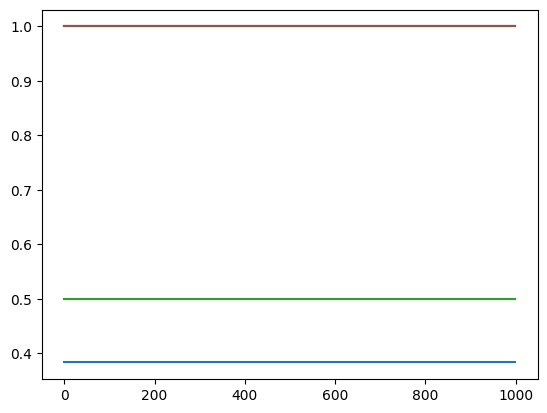

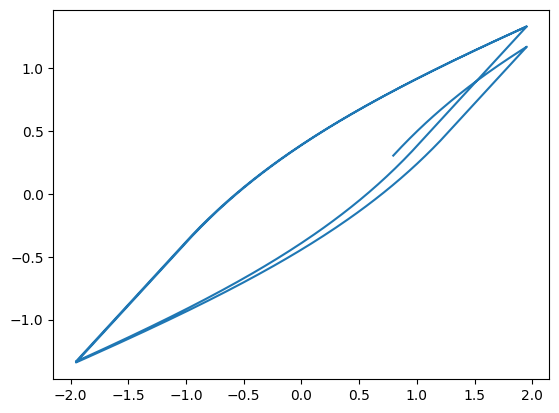

In [370]:
check_num = 21
plt.plot(param_data[check_num])
plt.show()
plt.plot(displacement_data[check_num], force_data[check_num])
plt.show()

In [350]:
fault_labels

array([0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 3, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0])

In [326]:
dataset = BoucWenDatasetNormalized(displacement_data, force_data, fault_labels, param_data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    

정규화 완료:
  Displacement - Mean: 0.012708, Std: 0.884129
  Force - Mean: -0.107727, Std: 0.786725


In [19]:
def analyze_data_statistics(displacement_data, force_data):
    """데이터 통계 분석"""
    print("=== 데이터 통계 분석 ===")
    print(f"Displacement - Min: {displacement_data.min():.6f}, Max: {displacement_data.max():.6f}")
    print(f"Displacement - Mean: {displacement_data.mean():.6f}, Std: {displacement_data.std():.6f}")
    print(f"Force - Min: {force_data.min():.6f}, Max: {force_data.max():.6f}")
    print(f"Force - Mean: {force_data.mean():.6f}, Std: {force_data.std():.6f}")
    
    # NaN, Inf 체크
    print(f"Displacement NaN: {np.isnan(displacement_data).sum()}")
    print(f"Displacement Inf: {np.isinf(displacement_data).sum()}")
    print(f"Force NaN: {np.isnan(force_data).sum()}")
    print(f"Force Inf: {np.isinf(force_data).sum()}")

In [20]:
analyze_data_statistics(displacement_data, force_data)

=== 데이터 통계 분석 ===
Displacement - Min: -1.987612, Max: 1.987618
Displacement - Mean: 0.000771, Std: 0.948198
Force - Min: -6.820656, Max: 4.958684
Force - Mean: -2.695548, Std: 2.123126
Displacement NaN: 0
Displacement Inf: 0
Force NaN: 0
Force Inf: 0


In [391]:
(0%5 == 0) & (5%5 == 0)

True

In [132]:
model = BoucWenVAE(
    input_dim=2,
    latent_dim=LATENT_DIM,
    d_model=512,
    n_heads=8,
    n_layers=2,
    seq_len=SEQ_LEN,
    dropout=0.1
).to(device)

In [ ]:
train_history = train_bouc_wen_vae(
        model=model,
        dataloader=dataloader,
        device=device,
        epochs=5,
        learning_rate=LEARNING_RATE,
        dt=DT
    )

🚀 Bouc-Wen VAE 학습 시작!
에포크 수: 5
학습률: 0.0001
배치 크기: 16
디바이스: cuda:0
Epoch 1/5, Batch 0: Total = 33.219582, Recon = 1.048600, Change Penalty = 0.000212, Physics = 16.078247


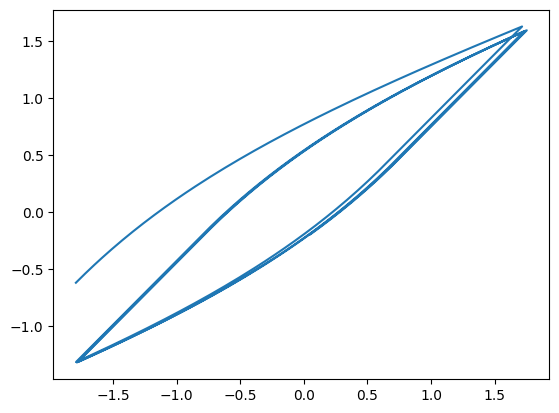

In [377]:
check_num = 16
plt.plot(dataset.displacement[check_num], dataset.force[check_num])

In [396]:
dataset.displacement

tensor([[-0.3838, -0.3931, -0.4025,  ..., -0.2224, -0.2333, -0.2442],
        [ 1.5438,  1.5376,  1.5314,  ..., -0.0260, -0.0573, -0.0886],
        [ 2.0172,  2.0083,  1.9994,  ..., -1.7793, -1.7980, -1.8167],
        ...,
        [-0.0584, -0.0417, -0.0251,  ...,  0.1554,  0.1724,  0.1893],
        [-1.4095, -1.3564, -1.3033,  ..., -1.5574, -1.6047, -1.6520],
        [-0.7033, -0.6923, -0.6812,  ..., -0.5980, -0.6117, -0.6255]])

In [394]:
dataset.force

tensor([[ 0.0046, -0.0059, -0.0163,  ..., -0.1873, -0.1971, -0.2068],
        [ 0.7167,  0.7097,  0.7028,  ..., -0.2200, -0.2452, -0.2701],
        [ 0.9064,  0.8964,  0.8865,  ..., -1.3000, -1.3083, -1.3165],
        ...,
        [ 0.1205,  0.1390,  0.1574,  ...,  0.3821,  0.3983,  0.4143],
        [-0.3806, -0.3218, -0.2648,  ..., -1.1888, -1.2104, -1.2318],
        [-0.1191, -0.1068, -0.0945,  ..., -0.4818, -0.4923, -0.5028]])

In [398]:
from torch.utils.data import DataLoader, TensorDataset

In [452]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ----- 데이터 -----
disp  = dataset.displacement.float()   # (B, T)
force = dataset.force.float()          # (B, T)
B, T = disp.shape
X = torch.stack([disp, force], dim=-1) # (B, T, 2)

loader = DataLoader(TensorDataset(X, X), batch_size=16, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----- AE (Encoder-Decoder with cross-attention) -----
class TransAE(nn.Module):
    def __init__(self, input_dim=2, d_model=128, n_heads=8, n_layers=2, seq_len=1000, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len

        # Encoder
        self.proj_in = nn.Linear(input_dim, d_model)
        self.pos_enc_enc = nn.Parameter(torch.zeros(1, seq_len, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                               dim_feedforward=4*d_model, dropout=dropout,
                                               batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # Decoder queries (learned) + positional enc
        self.query_tokens = nn.Parameter(torch.zeros(1, seq_len, d_model))
        self.pos_enc_dec  = nn.Parameter(torch.zeros(1, seq_len, d_model))
        dec_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads,
                                               dim_feedforward=4*d_model, dropout=dropout,
                                               batch_first=True)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=n_layers)

        self.proj_out = nn.Linear(d_model, input_dim)

    def forward(self, x):           # x: (B, T, 2)
        B, T, _ = x.shape

        # Encoder memory
        h = self.proj_in(x) + self.pos_enc_enc[:, :T, :]     # (B, T, d)
        mem = self.encoder(h)                                 # (B, T, d)

        # Decoder queries (one per timestep)
        tgt = self.query_tokens[:, :T, :].expand(B, -1, -1) + self.pos_enc_dec[:, :T, :]
        dec = self.decoder(tgt=tgt, memory=mem)               # (B, T, d)
        y = self.proj_out(dec)                                # (B, T, 2)
        return y

model = TransAE(input_dim=2, d_model=256, n_heads=8, n_layers=2, seq_len=T).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----- 학습 -----
for ep in range(50):
    model.train(); total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        recon = model(xb)
        loss = criterion(recon, yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    if (ep+1) % 10 == 0:
        print(f"[{ep+1:03d}] loss={total/len(loader.dataset):.6f}")

# ----- 사용 -----
model.eval()
with torch.no_grad():
    recon = model(X.to(device)).cpu()     # (B, T, 2)
    disp_hat, force_hat = recon[...,0], recon[...,1]


[010] loss=0.962299
[020] loss=0.942434
[030] loss=0.934802
[040] loss=0.916339
[050] loss=0.922401


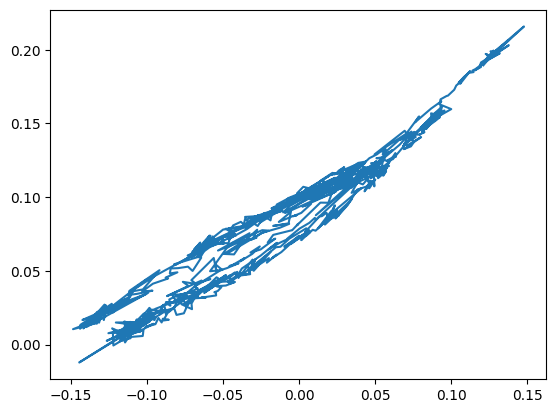

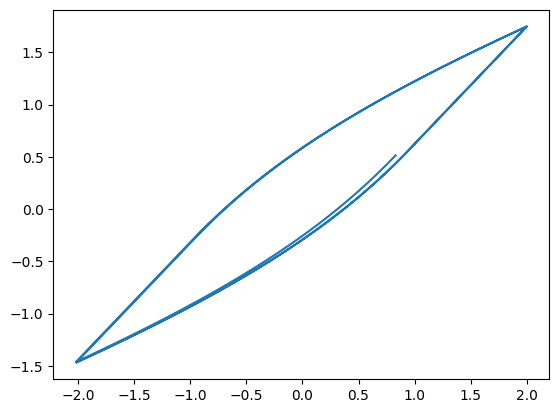

In [464]:
check_num = 17
plt.plot(disp_hat[check_num], force_hat[check_num])
plt.show()

plt.plot(dataset.displacement[check_num], dataset.force[check_num])
plt.show()